In [1]:
# 다중 레이블 분류 : 이미지당 하나 이상의 레이블을 예측하는 문제
# 회귀 : 하나 이상의 수로 표현될 때의 문제
# - 이 과정에서 딥러닝 모델의 출력 활성, 타깃, 손실 함수를 좀 더 깊게 학습

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


#hide
from fastbook import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *

path = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(path/'train.csv') # 팬더스는 데이터프레임 형식으로 CSV 파일을 불러오고 살펴보는 기능을 제공함
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [3]:
# 데이터블록 구성하기
# 학습용 및 검증용 데이터셋을 표현하고 접근하는 두 가지 주요 클래스를 제공함
# - Dataset : 단일 데이터를 표현하는 독립변수 및 종속변수 튜플을 반환함
# - DataLoader : 미니배치 스트림을 제공하는 반복자로, 각 미니배치는 여러 독립변수와 여러 종속변수에 대한 튜플로 구성됨
dblock = DataBlock()
dsets = dblock.datasets(df)
dsets.train[0]

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [5]:
dblock = DataBlock(get_x = lambda r : r['fname'], get_y = lambda r : r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [8]:
# 이미지를 열려면 완전한 경로로 독립변수를 구성해야함
# 그리고 공백 문자로 쪼개진 목록을 종속변수로 레이블을 구성함

def get_x(r) :
  return path/'train'/r['fname']

def get_y(r) :
  return r['labels'].split(' ')

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/004347.jpg'), ['bird'])

In [6]:
# lmabda 함수는 빠른 실험에는 굉장히 좋지만, 직렬화를 지원하지 않으므로 학습된 모델의 Learner 를 다른 환경으로 내보내려면
# 일반적인 방식으로 정의하는 편이 바람직함

def get_x(r) :
  return r['fname']

def get_y(r) :
  return r['labels']

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002844.jpg', 'train')

In [10]:
# MultiCategoryBlock을 통해서 다중 레이블을 반환하는 블록 처리
# MultiCategoryBlock은 범주가 있는 부분만 1로 채워진(나머지는 0) 정수 벡터로 표현함

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [11]:
idxs = torch.where(dsets.train[0][1] == 1.)[0] # 참이나 거짓인 조건에 부합하는 모든 색인을 찾아주는 편리한 torch.where함수 사용
dsets.train.vocab[idxs]

(#1) ['bird']

In [12]:
# 밑에 함수는 전체 데이터 목록을 수용하여 정수로 구성된 두 개 이상의 리스트를 반환해야 함
def splitter(df) :
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()

  return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]



(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

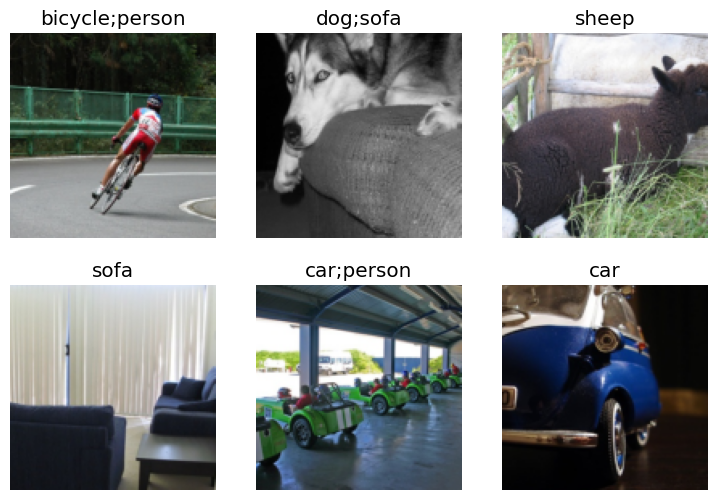

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)
dls.show_batch(nrows=2, ncols=3) # 만들어진 DataLoaders에서 표본 출력


In [24]:
# 이진 교차 엔트로피
learn = vision_learner(dls, resnet18)

x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape # 설정한 배치 크기가 64이고, 범주 20개에 대한 확률을 계산함

torch.Size([64, 20])

In [25]:
# 해당 미니배치를 통과시켜 얻은 activs가 포함한 결과 하나를 조사하여 출력 활성을 구성한 값들을 확인해보기
activs[0]

TensorImage([ 2.0042e+00,  3.4504e+00,  1.8251e+00,  1.9201e-01, -1.0576e-03,  2.2889e+00,  2.7477e+00,  2.4218e-01,  8.6402e-01, -8.6653e-01,  1.1150e+00, -4.3049e-01,  2.9798e-01,  1.2269e+00,
             -2.5990e-01,  1.9018e+00,  7.2876e-01, -1.0577e+00,  2.2110e+00,  3.8002e+00], grad_fn=<AliasBackward0>)

In [29]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss



TypeError: no implementation found for 'torch.nn.functional.binary_cross_entropy_with_logits' on types that implement __torch_function__: [<class 'fastai.torch_core.TensorImage'>, <class 'fastai.torch_core.TensorMultiCategory'>]

In [31]:
# 정확도는 예측된 출력과 타깃을 다음과 같이 비교하여 계산함
def accuracy(inp, targ, axis=-1) :
  "'pred'가 'bs*n_classes(배치 크기 * 범주 개수)일 때, 'targ'로 정확도를 계산함"
  pred = inp.argmax(dim=axis)
  return (pred == targ).float().mean()

# 범위를 0~1로 만들려고 출력 활성에 시그모이드를 적용한 다음에는 활성 중 어떤 값을 0, 1로
# 간주할지를 정하는 임계점을 선택해야함
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True) :
  "'inp'와 'targ'의 크기가 같을 때 정확도를 계산함"
  if sigmoid: inp = inp.sigmoid()

  return ((inp>thresh) == targ.bool()).float().mean()

def say_hello(name, say_what="Hello") :
  return f"{say_what} {name}."

say_hello('yeonuel')
say_hello('yeonuel', 'hahaha')

'hahaha yeonuel.'

In [32]:
# 모델을 학습 시키기
# 0.2로 설정된 평가지표의 정확도 임계점으로 시도
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.946012,0.685543,0.234363,00:28
1,0.822865,0.543312,0.290119,00:26
2,0.603831,0.194006,0.826414,00:36
3,0.359203,0.117470,0.944781,00:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.126171,0.102499,0.954422,00:30
1,0.113605,0.094045,0.955737,00:30
2,0.098328,0.093326,0.957171,00:29


In [33]:
# 임계점을 낮게 설정하고 검증용 데이터셋의 손실과 평가지표를 반환하는 validate 메서드를 호출하면
# 이를 확인할 수 있음

# - 임계점이 너무 낮으면 레이블링된 물체를 선택하지 못할 가능성이 높음
# - 임계점이 너무 높으면 모델이 자신 있는 물체 단 하나만 선택할 가능성이 높음
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.09332618862390518,0.9387250542640686]

In [35]:
# 몇 가지 다른 임계점을 시도해서 어떤 값에서 가장 잘 작동하는지를 확인하여 최적의 임계점을 발견할 수 있습니다.
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9596)

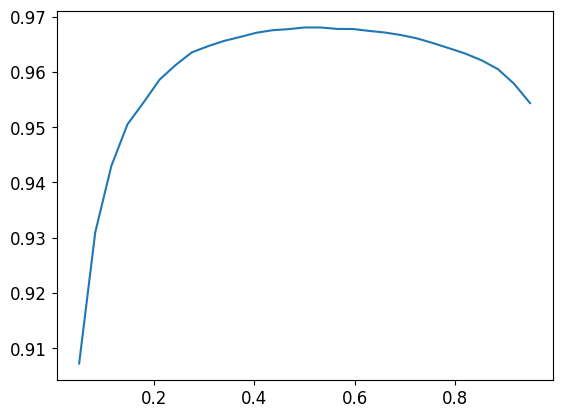

In [36]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [37]:
# 이미지 회귀
# - 독립변수에는 이미지, 종속변수에는 하나 이상의 부동소수를 둔 데이터셋을 학습하는 문제

# 데이터 조힙
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/08'),Path('/root/.fastai/data/biwi_head_pose/06'),Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/21.obj'),Path('/root/.fastai/data/biwi_head_pose/14'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/09.obj'),Path('/root/.fastai/data/biwi_head_pose/05.obj'),Path('/root/.fastai/data/biwi_head_pose/readme.txt')...]

In [38]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00109_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00274_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00028_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00355_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00240_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00095_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00307_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00084_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00043_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00060_rgb.jpg')...]

In [39]:
# get_image_files 함수를 사용하면 모든 이미지 파일을 재귀로 쉽게 가져올 수 있음
# 다음으로는 이미지 파일명에 해당하는 포즈 파일명을 반환 함수

img_files = get_image_files(path)
def img2pose(x) :
  return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/08/frame_00109_pose.txt')

In [42]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

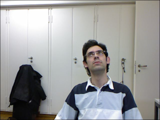

In [41]:
im.to_thumb(160)

In [43]:
# 부연 설명 없이 포즈 파일에서 머리의 중심 위치를 추출하는 함수를 보여주기
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

# 해당 함수는 좌표 요소가 둘인 텐서를 반환함
get_ctr(img_files[0])

tensor([392.9883, 229.0186])

In [44]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)),
)

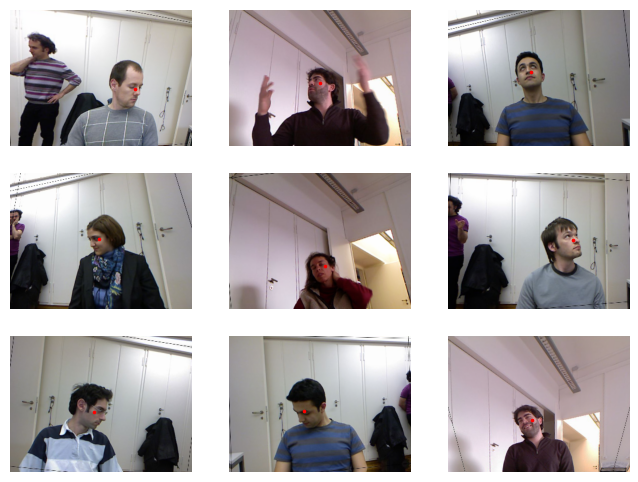

In [46]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6)) # 실제 모델링하기 전에 이미지와 레이블 데이터가 정상인지 확인

In [47]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [48]:
yb[0]

TensorPoint([[-0.2320,  0.1036]], device='cuda:0')

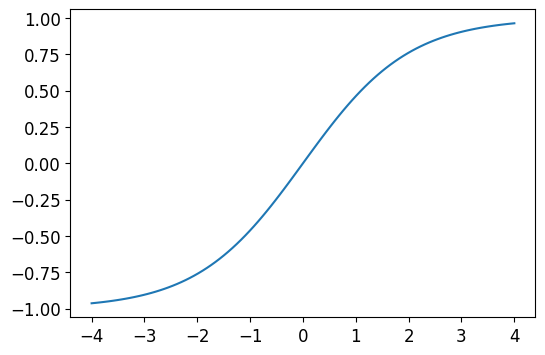

In [51]:
# 모델 학습
learn = vision_learner(dls, resnet18, y_range=(-1,1))

def sigmoid_range(x, lo, hi) :
  return torch.sigmoid(x) * (hi - lo) + lo

plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [52]:
dls.loss_func

FlattenedLoss of MSELoss()

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0030199517495930195)

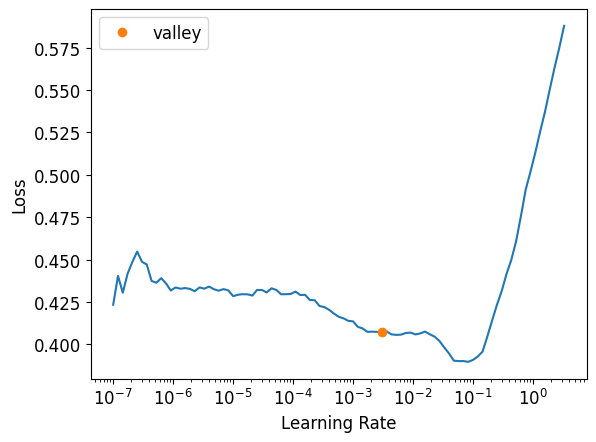

In [53]:
learn.lr_find()

In [56]:
lr = 1e-2
learn.fine_tune(3, base_lr=lr)

epoch,train_loss,valid_loss,time
0,0.003949,0.000933,01:42


epoch,train_loss,valid_loss,time
0,0.002060,0.000507,01:52
1,0.001446,0.000071,01:53
2,0.001065,0.000035,01:53


In [57]:
math.sqrt(0.0001)


0.01

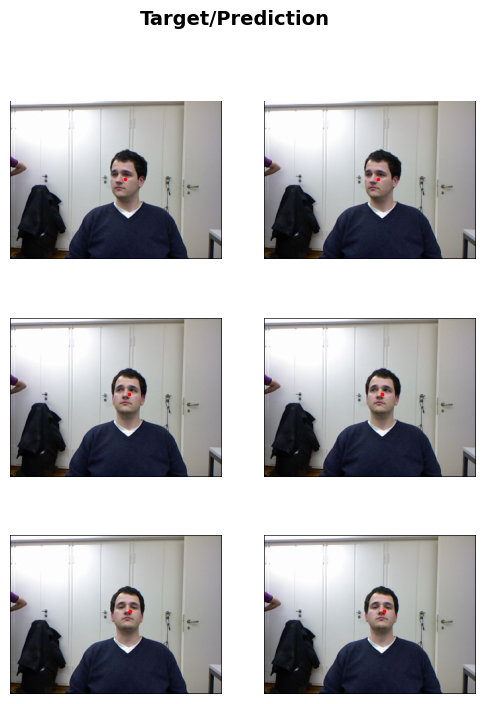

In [58]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6, 8))